# Gaussian Process Regression

At times you don't care about the underlying model for your data points and just want a model that describes the data.  One such fitting technique is know as Gaussian process regression (also know as kriging).  This kind of regression assumes all the data points are drawn from a common covariance function.  This function is used to generate an (infinite) set of functions and only keeps the ones that pass through the observed data.

## Packages being used
+ `pymc3`: has a Gaussian process regression function

## Relevant documentation
+ `pymc3`: https://docs.pymc.io/notebooks/GP-MeansAndCovs.html, https://docs.pymc.io/notebooks/GP-Marginal.html

In [2]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
from scipy import interpolate
import seaborn
from matplotlib import pyplot as plt
import mpl_style
%matplotlib inline
plt.style.use(mpl_style.style1)
seaborn.axes_style(mpl_style.style1);

In [3]:
import warnings
warnings.simplefilter('ignore')

## The squared exponential covariance (or Radial-basis function or Exponential Quadratic)
As an example we will use the squared exponential covariance function:
$$ \operatorname{Cov}{(x_1, x_2; h)} = \exp{\left( \frac{-(x_1 - x_2)^2}{2h^2} \right)} $$
Lets using this function to draw some _unconstrained_ functions:

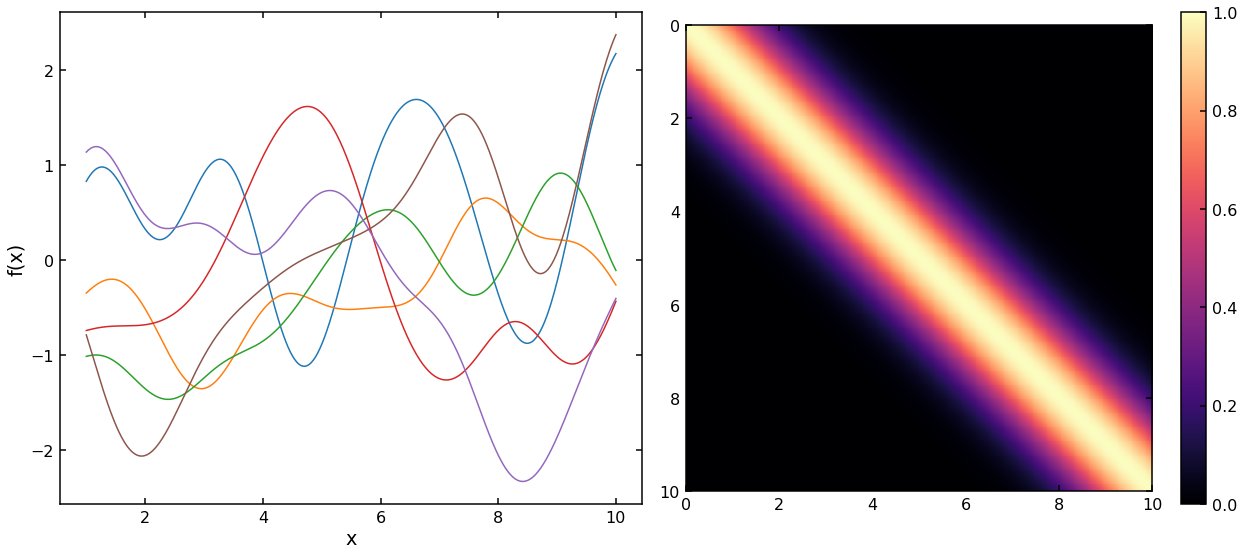

In [4]:
h = 1
cov = pm.gp.cov.ExpQuad(1, h)

x = np.linspace(1, 10, 500)[:, None]
K = cov(x).eval()

plt.figure(1, figsize=(18, 8))

plt.subplot(121)
plt.plot(x, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=6).T)
plt.xlabel('x')
plt.ylabel('f(x)')

plt.subplot(122)
plt.imshow(K, interpolation='none', origin='upper', extent=[0, 10, 10, 0])
plt.colorbar()
plt.tight_layout();

## Constrain the model

Assume we have some data points, we can use Gaussian process regression to only pick the models that pass through those points:

In [5]:
x1 = np.array([1, 3, 5, 6, 7, 8])
y1 = x1 * np.sin(x1)

### Build the PYMC model
We will define priors for the length scale `h` and the leading scaling coefficient `c`.  We will assume there is a small level of equal but unknown noise associated with each data point.

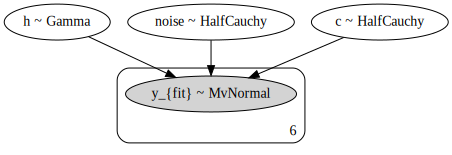

In [6]:
X = x1[:, None]
with pm.Model() as model:
    h = pm.Gamma("h", alpha=2, beta=1)
    c = pm.HalfCauchy("c", beta=5)
    cov = c**2 * pm.gp.cov.ExpQuad(1, ls=h)
    gp = pm.gp.Marginal(cov_func=cov)
    noise = pm.HalfCauchy("noise", beta=0.1)
    y_fit = gp.marginal_likelihood("y_{fit}", X=X, y=y1, noise=noise)

display(model)
display(pm.model_to_graphviz(model))

Find the maximum of the likelihood using the `find_MAP` function.

In [7]:
with model:
    mp = pm.find_MAP()

display('Best fit kernel: {0:.2f}**2 * ExpQuad(ls={1:.2f})'.format(mp['c'], mp['h']))

logp = -16.448, ||grad|| = 0.0003648: 100%|██████████| 36/36 [00:00<00:00, 211.60it/s]  


'Best fit kernel: 4.16**2 * ExpQuad(ls=1.58)'

### Use the fit to interpolate to new `X` values
This `MAP` fit can be used to interpolate and extrapolate to a new grid of points.  PYMC offers the `predict` method to make this easier.

In [8]:
n_new = 500
X_new = np.linspace(0, 10, n_new)

mu, var = gp.predict(X_new[:,None], point=mp, diag=True)
sd = np.sqrt(var)

Let's plot the result:

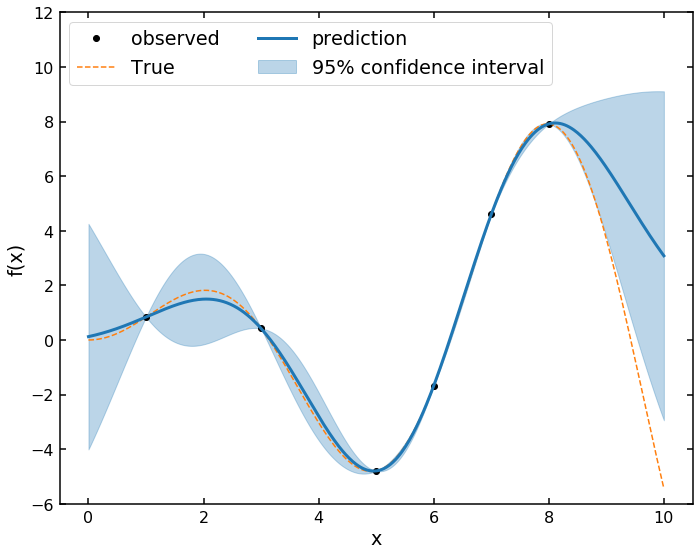

In [9]:
plt.figure(2, figsize=(10, 8))
plt.plot(x1, y1, 'ok', label='observed')

plt.plot(
    X_new,
    X_new * np.sin(X_new),
    '--',
    color='C1',
    label='True'
)

plt.plot(
    X_new.flatten(),
    mu,
    color='C0',
    lw=3,
    zorder=3,
    label='prediction'
)

# plot 95% best fit region
plt.fill_between(
    X_new.flatten(),
    mu - 1.96*sd,
    mu + 1.96*sd,
    color='C0',
    alpha=0.3,
    zorder=1,
    label='95% confidence interval'
)

# labels and legend
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-6, 12)
plt.legend(loc='upper left', ncol=2)
plt.tight_layout();

## Sampling from the data
Sometimes you want to know the values of the covariance function and draw samples from the posterior distribution.  We can do easily do this within PYMC with the `sample` method:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [noise, c, h]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:47<00:00, 80.06draws/s] 
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
h,1.5173,0.4699,0.0137,0.5265,2.3762,1154.3856,1.0008
c,5.6303,2.9436,0.0796,2.3813,10.9206,1081.8971,0.9998
noise,0.2428,0.5471,0.0160,0.0003,0.9141,878.1250,0.9998


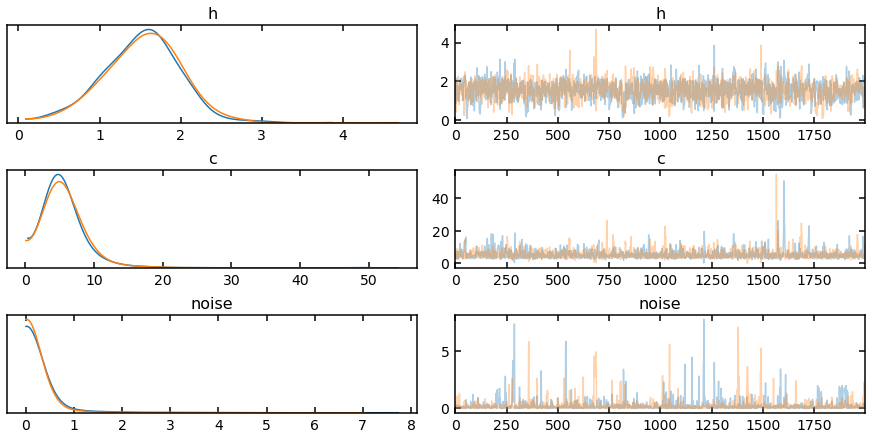

In [10]:
with model:
    trace = pm.sample(2000, target_accept=0.95)

display(pm.summary(trace).round(4))
pm.traceplot(trace);

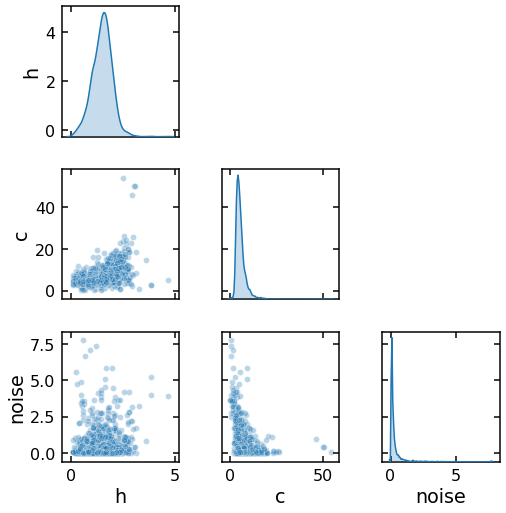

In [11]:
df = pm.trace_to_dataframe(trace)

def hide_current_axis(*args, **kwargs):
    plt.gca().set_visible(False)

g = seaborn.pairplot(
    df,
    diag_kind='kde',
    plot_kws={'alpha': 0.3}
)
g.map_upper(hide_current_axis)
seaborn.despine(top=False, right=False)

Notice the trade off between the noise level and the `c` parameter.  When `c` becomes small the noise becomes large, i.e. it models all the points as coming from a flat line with high noise.

Now that we have sampled from the distribution we can interpolate/extrapolate the fitted function.  To do this we have to pass the new `X` values into the model as a `conditional`:

In [12]:
with model:
    f_new = gp.conditional('f_new', Xnew=X_new[:, None])

Finally we can draw samples of these conditional fits from the posterior using `sample_ppc`:

In [13]:
with model:
    ppc = pm.sample_ppc(trace, samples=200, vars=[f_new])

100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Finally we can make a plot of these samples using the `plot_gp_dist` utility function:

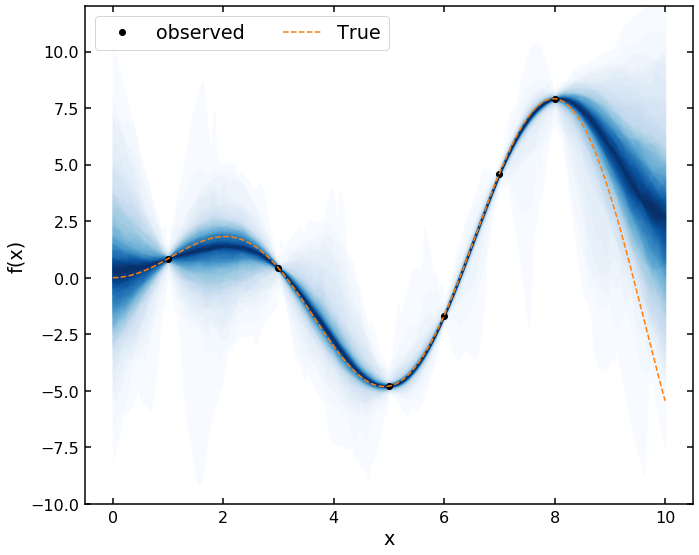

In [14]:
plt.figure(6, figsize=(10, 8))
ax = plt.gca()

plt.plot(x1, y1, 'ok', label='observed')

pm.gp.util.plot_gp_dist(
    ax,
    ppc['f_new'],
    X_new,
    plot_samples=False,
    palette="Blues",
    fill_alpha=1
)

plt.plot(
    X_new,
    X_new * np.sin(X_new),
    '--',
    color='C1',
    label='True'
)

plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-10, 12)
plt.legend(loc='upper left', ncol=2)
plt.tight_layout();

We can see that this is slightly different than previous plot, this is due the the nature of the fitting process used.  In the first case we used the maximum of the likelihood distribution as a point estimate of the best fit, and in the second case we sampled directly from the likelihood.

## Noisy data
Let's add some noise to the data.  We will assume each data point has independent errorbars.  These values can be passed directly into the `marginal_likelihood` function instead of the prior we were using before.

In [15]:
dy = 0.5 + np.random.random(y1.shape)
y_noise = np.random.normal(0, dy)
y2 = y1 + y_noise

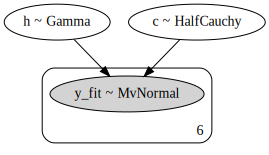

In [16]:
with pm.Model() as model_noise:
    h = pm.Gamma("h", alpha=2, beta=1)
    c = pm.HalfCauchy("c", beta=5)
    cov = c**2 * pm.gp.cov.ExpQuad(1, ls=h)
    gp = pm.gp.Marginal(cov_func=cov)
    y_fit = gp.marginal_likelihood("y_fit", X=X, y=y2, noise=dy)

display(model_noise)
display(pm.model_to_graphviz(model_noise))

In [17]:
with model_noise:
    mp_noise = pm.find_MAP()

display('Best fit kernel: {0:.2f}**2 * ExpQuad(ls={1:.2f})'.format(mp_noise['c'], mp_noise['h']))

logp = -24.234, ||grad|| = 12.764: 100%|██████████| 10/10 [00:00<00:00, 689.80it/s]


'Best fit kernel: 4.57**2 * ExpQuad(ls=0.91)'

### Plot the results
As before we can interpolate and extrapolate to new points.

In [18]:
mu_noise, var_noise = gp.predict(X_new[:,None], point=mp_noise, diag=True)
sd_noise = np.sqrt(var_noise)

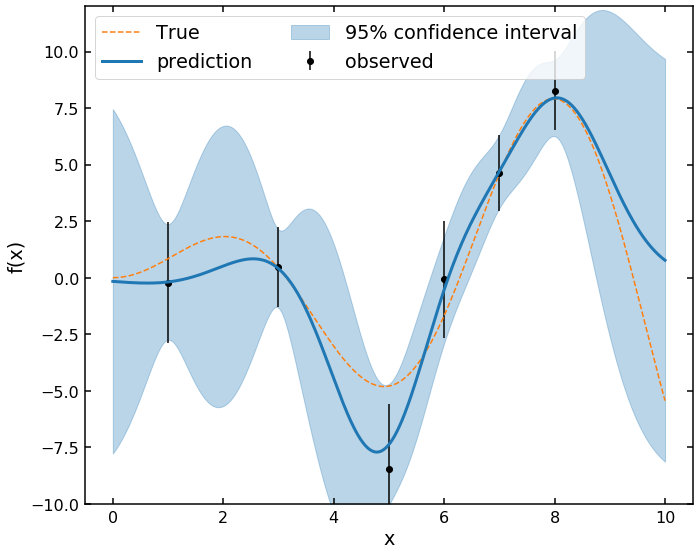

In [19]:
plt.figure(3, figsize=(10, 8))
plt.errorbar(x1, y2, yerr=1.96*dy, fmt='ok', label='observed')

plt.plot(
    X_new,
    X_new * np.sin(X_new),
    '--',
    color='C1',
    label='True'
)

plt.plot(
    X_new.flatten(),
    mu_noise,
    color='C0',
    lw=3,
    zorder=3,
    label='prediction'
)

# plot 95% best fit region
plt.fill_between(
    X_new.flatten(),
    mu_noise - 1.96*sd_noise,
    mu_noise + 1.96*sd_noise,
    color='C0',
    alpha=0.3,
    zorder=1,
    label='95% confidence interval'
)

# labels and legend
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-10, 12)
plt.legend(loc='upper left', ncol=2)
plt.tight_layout();

## A Cubic Spline
So far we have been using the `ExpQuad` kernel, but it there are others that can be used.  You may have noticed that this method of fitting provides smooth curves that pass through the data points very similar to how a spline fit does.  As it turns out, a spline fit is just a special case of a Gaussian process fit.  To recreate a cubic spline we can use the following kernel:
$$ \operatorname{Cov}(x_1, x_2) = 1 + \lvert x_1 - x_2 \rvert \frac{\min(x_1, x_2)^2}{2} + \frac{\min(x_1, x_2)^3}{3}$$

Under the condition that all values of $x_1$ and $x_2$ are between the values of $0$ and $1$.  This normalization ensure that the covariance matrix is positive definite.  So unlike other kernels we will needed to know the range we plan to extrapolate onto before doing our fit.

This kernel is not built into `pymc3` so we will have to write a custom kernel for it:

In [20]:
class CubicSpline(pm.gp.cov.Covariance):
    def __init__(self, dim, x_min=0, x_max=1):
        super(CubicSpline, self).__init__(1, None)
        self.x_min = x_min
        self.x_max = x_max

    def norm(self, X):
        d = self.x_max - self.x_min
        return (X - self.x_min) / d

    def diag(self, X):
        X, _ = self._slice(X, Xs=None)
        X = self.norm(X)
        Xt = tt.flatten(X)
        return 1 + (Xt**3) / 3

    def full(self, X, Xs=None):
        X, Xs = self._slice(X, Xs)
        if Xs is None:
            Xs = X
        X = self.norm(X)
        Xs = self.norm(Xs)
        d = tt.abs_(X - tt.transpose(Xs))
        v = tt.minimum(X, tt.transpose(Xs))
        k = 1 + (0.5 * d * v**2) + ((v**3) / 3)
        return k

Now we can fit for this kernel's coefficient.  The prior for the noise is pushed to lower values to ensure the fit does not treat the data as "noise only."

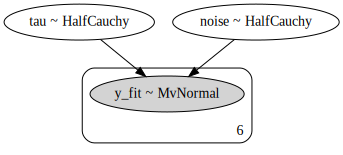

In [21]:
with pm.Model() as model_cube:
    tau = pm.HalfCauchy('tau', beta=5)
    # we know we will be interpolating onto points between 0 and 10, so initalize the spline kernel with these values
    cov = CubicSpline(1, x_min=0, x_max=10) * tau**2
    gp = pm.gp.Marginal(cov_func=cov)
    noise = pm.HalfCauchy('noise', beta=0.1)
    y_fit = gp.marginal_likelihood("y_fit", X=x1[:, None], y=y1, noise=noise)

display(model_cube)
display(pm.model_to_graphviz(model_cube))

In [23]:
with model_cube:
    mp_cube = pm.find_MAP()

display('{0:.2f}**2 * CubicSpline'.format(mp_cube['tau']))

logp = -27.037, ||grad|| = 0.045779: 100%|██████████| 31/31 [00:00<00:00, 648.86it/s]  


'96.42**2 * CubicSpline'

In [24]:
mu_cube, var_cube = gp.predict(X_new[:,None], point=mp_cube, diag=True)
sd_cube = np.sqrt(var_cube)

We will also fit a cubic spline to the data and compare it to the Gaussian process fit.

In [25]:
tck = interpolate.splrep(x1, y1, k=3)
y_new = interpolate.splev(X_new, tck)

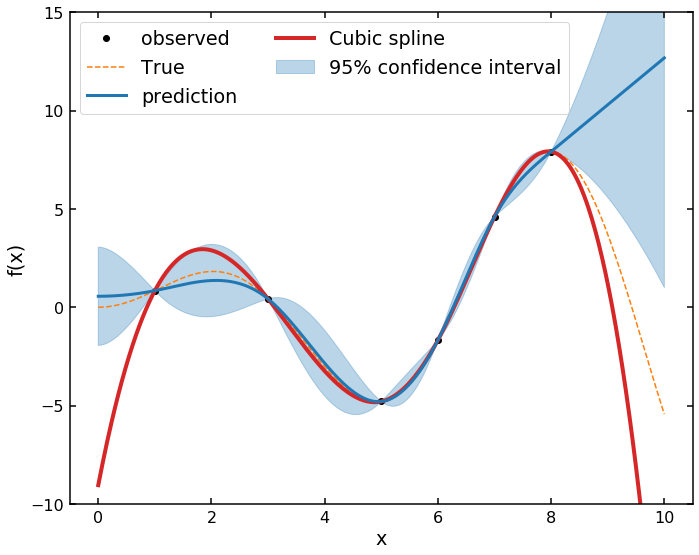

In [27]:
plt.figure(4, figsize=(10, 8))
plt.plot(x1, y1, 'ok', label='observed')

plt.plot(
    X_new,
    X_new * np.sin(X_new),
    '--',
    color='C1',
    label='True'
)

plt.plot(
    X_new.flatten(),
    mu_cube,
    color='C0',
    lw=3,
    zorder=3,
    label='prediction'
)

# plot 95% best fit region
plt.fill_between(
    X_new.flatten(),
    mu_cube - 1.96*sd_cube,
    mu_cube + 1.96*sd_cube,
    color='C0',
    alpha=0.3,
    zorder=1,
    label='95% confidence interval'
)

plt.plot(X_new, y_new, color='C3', label='Cubic spline', lw=4)

# labels and legend
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-10, 15)
plt.legend(loc='upper left', ncol=2)
plt.tight_layout();

Notice that aside from the end points the Gaussian process the the spline give the same result.  Additionally we now have an errorbar estimate for a spline fit!

## Adding noise to the spline fit
Now that we have this working we can include measurement errors on each of the data points like we did before.

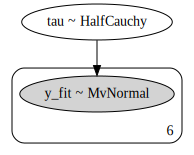

In [28]:
with pm.Model() as model_cube_err:
    tau = pm.HalfCauchy('tau', beta=5)
    cov = CubicSpline(1, x_min=0, x_max=10) * tau**2
    gp = pm.gp.Marginal(cov_func=cov)
    y_fit = gp.marginal_likelihood("y_fit", X=x1[:, None], y=y2, noise=dy)

display(model_cube_err)
display(pm.model_to_graphviz(model_cube_err))

In [29]:
with model_cube_err:
    mp_cube_err = pm.find_MAP()

display('{0:.2f}**2 * CubicSpline'.format(mp_cube_err['tau']))

logp = -48.621, ||grad|| = 10.082: 100%|██████████| 7/7 [00:00<00:00, 644.03it/s]


'104.42**2 * CubicSpline'

In [30]:
mu_cube_err, var_cube_err = gp.predict(X_new[:,None], point=mp_cube_err, diag=True)
sd_cube_err = np.sqrt(var_cube_err)

In [31]:
tck_noise = interpolate.splrep(x1, y2, k=3)
y_new_noise = interpolate.splev(X_new, tck_noise)

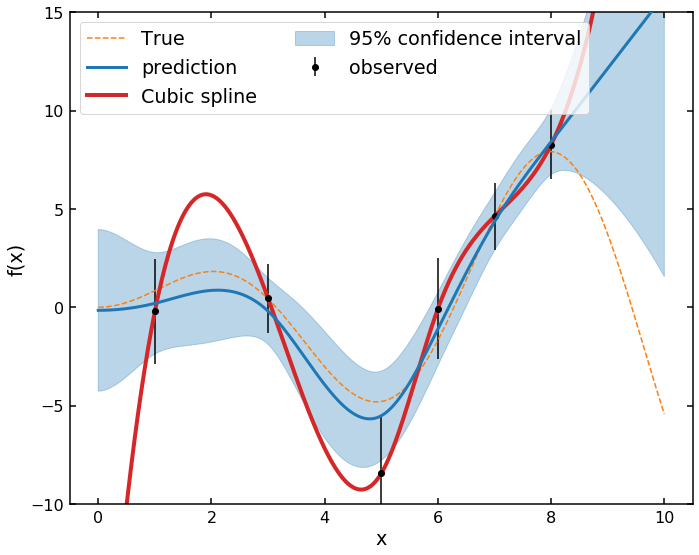

In [32]:
plt.figure(5, figsize=(10, 8))
plt.errorbar(x1, y2, yerr=1.96*dy, fmt='ok', label='observed')

plt.plot(
    X_new,
    X_new * np.sin(X_new),
    '--',
    color='C1',
    label='True'
)

plt.plot(
    X_new.flatten(),
    mu_cube_err,
    color='C0',
    lw=3,
    zorder=3,
    label='prediction'
)

# plot 95% best fit region
plt.fill_between(
    X_new.flatten(),
    mu_cube_err - 1.96*sd_cube_err,
    mu_cube_err + 1.96*sd_cube_err,
    color='C0',
    alpha=0.3,
    zorder=1,
    label='95% confidence interval'
)

plt.plot(X_new, y_new_noise, color='C3', label='Cubic spline', lw=4)

# labels and legend
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-10, 15)
plt.legend(loc='upper left', ncol=2)
plt.tight_layout();

## Other notes
+ There are many covariance kernels you can pick;
    + `Constant`: a constant value that can be multiplied or added to any of the other kernels
    + `WhiteNoise`: a white noise kernel
    + `ExpQud`: exponentiated quadratic, smooth kernel parameterized by a length-scale
    + `RatQuad`: rational quadratic, a (infinite sum) mixture of different `ExpQud`'s each with different length-scales
    + `Exponential`: Similar to `ExpQud` but without the square in the exponent.
    + `Marten52`: Marten 5/2 non-smooth generalization of `RBF`, parameterized by length-scale and smoothness
    + `Marten32`: Marten 3/2 non-smooth generalization of `RBF`, parameterized by length-scale and smoothness
    + `Cosine`: periodic kernel built with `cos`
    + `Linear`: a non-stationary kernel that can be used to fit a line
    + `Polynomial`: a non-stationary kernel commonly polynomial like fit
    + `Periodic`: periodic function kernel, parameterized by a length-scale and periodicity

+ There are also three mean functions to choose from:
    + `Zero`: The mean is all zeros (this is the default)
    + `Constant`: The mean is a constant value (i.e. a global y-offset)
    + `Linear`: The mean is a linear function (i.e. a polynomial)

+ See https://docs.pymc.io/notebooks/GP-MeansAndCovs.html for examples of each kernel and mean function
+ All `X` positions must be unique
+ The computational complexity is $O(N^3)$ where $N$ is the number of data point.  If you have a large number of data points you can use PYMC3's variational inference methods (https://docs.pymc.io/api/inference.html#variational) that replace the (complex) posterior with simpler approximations that are faster to compute.